# Loading MNIST DATA

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor()])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1000, shuffle=True)

In [29]:
images, labels = next(iter(trainloader))

In [28]:
images.shape

torch.Size([1000, 1, 28, 28])

In [5]:
torch.mean(images)

tensor(0.1275)

In [6]:
torch.std(images)

tensor(0.3046)

In [32]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.13), (0.3)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [33]:
images, labels = next(iter(trainloader))

In [35]:
Xsample = images.reshape(images.shape[0], -1)

In [36]:
Xsample.shape

torch.Size([64, 784])

### Problem 1: Constructing the network model

`FNC` class를 정의하고 `model`을 생성하세요:

- input layer
  - number of input features를 hidden unit 128개로 선형변환 및 ReLU activation function
- Hidden layer
  - 128 hidden unit을 64개 hidden unit으로 선형변환 및 ReLU
- Output layer
  - 64개 hidden unit을 10개 class로 분류하기 위한 output layer
  - 최종 layer의 activation은 없음 (linear layer)

In [8]:
class FCN(nn.Module):
    # 답작성
    def __init__(self):
        super().__init__()
        self.seq = True
    

In [37]:
model = FCN()

## Loss Functions in PyTorch

* 다음 과정으로, Pytorch에서 loss를 어떻게 연산하는지 배워보죠
* `nn` module에서 다양한 loss function을 제공하는데, 예를 들면 `nn.CrossEntropyLoss`와 같은 함수가 있습니다
    * 보통 관습적으로 loss function은 `critertion`이라는 변수로 받습니다 (`loss_function`등도 당연히 사용 가능합니다)
* 지난 시간에 MNIST 문제는 확률 분포를 output으로 받는 것이 필요하다고 (또는 자연스러운 선택 임을) 학습했습니다 
* 이런 확률 분포를 output으로 받는 경우 대응되는 좋은 loss function이 cross entropy입니다 (이론 강의에서 cross entropy가 무엇을 의미하는지 설명한 부분을 복습 해보세요)

* Cross entropy의 정의는 
\begin{align*}
 J(\theta) &=-\frac{1}{m}\sum_{i=1}^m P(y^{(i)}|x^{(i)})\log(Q(y^{(i)}|x^{(i)}))
\end{align*}
* 위 식은 두 확률 분포의 "거리"를 표현하는 식이라고 배웠습니다
* 위에서 $P(y|x)$는 $y$의 label을 one hot coding 한 vector이고 $Q(y|x)$는 softmax를 취한 network output입니다
* One hot coding은 label이 1이면 첫번째 자리만 '1'이고 나머지는 영인 벡터, label이 $k$이면 $k$ 번째 자리만 '1'이고 나머지는 0인 벡터입니다

* 예를들어서 label이 2에 대한 one hot encoding
\begin{align*}
y_\textrm{one\_hot}(2) &= \begin{array}{cccccc}
[0 & 0 & 1 & \cdots & 0]
\end{array}
\end{align*}

* 위 cross entropy 식에 대응 하는 방식은, label이 2라고 가정했을 때 분포는:
\begin{align*}
P(y|x) = y_\textrm{one\_hot}(2), \quad P(2|x) = (y_\textrm{one\_hot}(2))_2
\end{align*}

* 또한, neural network의 마지막 linear layer의 output 값이 $z$라고 할때,
\begin{align*}
Q(y=2|x) = \sigma(z_2) = \cfrac{\exp(z_2)}{\sum_k^K{\exp(z_k)}}
\end{align*}

<img src='https://drive.google.com/thumbnail?id=17hcl4RJne65Vd17gKM8XKUTjYlqyFIY5&sz=w1000' width="400" height="300">

* pytorch에서 이를 수행하기 위해서 criterion을 `nn.CrossEntropyLoss`로 생성하고, network의 예측 값과, 실제 label 값을 입력으로 loss를 계산합니다
  * 본 과정은 차근차근 설명하겠습니다
* 그 전에 Pytorch에서 cross entropy 함수를 어떻게 적용하는지 먼저 이해할 필요가 있습니다 (중요합니다!!!)
  * [Pytorch.org `nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss)를 살펴보면

> This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
>
> The input is expected to contain scores for each class.

* `nn.CrossEntropyLoss`는 `nn.LogSoftmax()`와 `nn.NLLLoss()` 하나의 class에서 수행한다고 되어 있습니다. 
* 두번째 줄에서 NLLLoss 는 negative log likelihood loss 입니다 

* 이게 의미하는 바가 무엇이냐면, network의 output을 softmax function을 적용하여 출력하지 말고, softmax는 loss function에서 계산한다는 뜻입니다
* 이렇게 구현한 이유는, 확률값이 작을 수 있어서 computation precision error를 방지하기 위해서 그냥 raw output 값을 받고, loss function에서 log(prob) 형태로 연산하도록 모듈을 구성하였습니다

* 아래 코드를 보면 조금 더 이해가 될 것이라고 생각합니다


In [43]:
criterion = nn.CrossEntropyLoss()
# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.reshape(images.shape[0], -1)

# Forward pass, get our log-probabilities
logits = model(images)
# Calculate the loss with the logps and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.3240, grad_fn=<NllLossBackward0>)


### Problem 2: Implement softmax

다음 `softmax` 함수를 만드세요

- `softmax(x)`
- `input`: (batchsize, num_class)의 최종 linear layer output
- `output`: `softmax` 취한 output이 (batchsize, softmaxoutput) 차원으로 정렬

- 유용할 수 있는 함수:
    - `torch.sum`
    - `torch.exp`
    - broadcasting 사용 (reshape)

In [44]:
logits.shape

torch.Size([64, 10])

In [13]:
# 답작성
def softmax(x):
    return True

In [52]:
ps = softmax(logits)

tensor([[0.0902, 0.0850, 0.1000, 0.1294, 0.1150, 0.0881, 0.1037, 0.1148, 0.0864,
         0.0873],
        [0.0968, 0.0827, 0.1110, 0.1244, 0.1038, 0.1014, 0.1016, 0.1083, 0.0843,
         0.0856],
        [0.0881, 0.0750, 0.0995, 0.1228, 0.1081, 0.0948, 0.1038, 0.1266, 0.0845,
         0.0968],
        [0.0850, 0.0588, 0.1118, 0.1159, 0.1153, 0.0863, 0.1169, 0.1277, 0.0877,
         0.0947],
        [0.0958, 0.0752, 0.1095, 0.1289, 0.1012, 0.0998, 0.1025, 0.1085, 0.0870,
         0.0915],
        [0.0865, 0.0648, 0.1015, 0.1343, 0.1132, 0.0864, 0.1105, 0.1313, 0.0812,
         0.0903],
        [0.0916, 0.0705, 0.1136, 0.1307, 0.0995, 0.1076, 0.0961, 0.1140, 0.0866,
         0.0898],
        [0.0910, 0.0733, 0.1110, 0.1093, 0.1064, 0.1048, 0.1094, 0.1298, 0.0798,
         0.0852],
        [0.0864, 0.0668, 0.1205, 0.1133, 0.1165, 0.1014, 0.0956, 0.1305, 0.0850,
         0.0840],
        [0.0859, 0.0804, 0.1075, 0.1212, 0.1044, 0.1030, 0.1093, 0.1157, 0.0876,
         0.0850],
        [0

### Problem 3: Finding the Highest probability index

Sample별 예측 확률값을 통하여 가장 높은 확률 값 예측 받는 함수를 작성하세요.

`get_pred(ps)`
- `input`: sample 별 확률값을 (batchsize, class probabilities) 로 받음
- `output`: sample 별로 가장 높은 확률값의 index를 return

- 유용할 수 있는 함수
  - `torch.argmax`



In [15]:
def get_pred(ps):
    # 답자가성
    return True
    

# Calculating Gradients

In [73]:

print('Before backward pass: \n', model.seq[0].weight.grad)

loss.backward()

print('After backward pass: \n', model.seq[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0013, -0.0013, -0.0013,  ..., -0.0013, -0.0013, -0.0013],
        [ 0.0005,  0.0005,  0.0005,  ...,  0.0005,  0.0005,  0.0005],
        [-0.0013, -0.0013, -0.0013,  ..., -0.0013, -0.0013, -0.0013],
        ...,
        [ 0.0015,  0.0015,  0.0015,  ...,  0.0015,  0.0015,  0.0015],
        [-0.0015, -0.0015, -0.0015,  ..., -0.0015, -0.0015, -0.0015],
        [-0.0003, -0.0003, -0.0003,  ..., -0.0003, -0.0003, -0.0003]])


## Training the network!


* 자, 그럼 network parameter에 대한 loss function의 gradient를 구했으니, 이제 최적화를 할 수 있습니다
* 최적화 기법은 SGD 이외에도 많으며 (SGD의 변형들임) [`optim` package](https://pytorch.org/docs/stable/optim.html)에서 찾아서 사용할 수 있습니다
* 예를 들어서 SGD는 `optim.SGD`를 통해서 불러올 수 있습니다
* 아래 예를 보죠

In [78]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.1)

* model.parameters()는 우리 network의 모든 training parameter이며, lr는 learning rate 입니다
* 자, 이제 traning에 필요한 모든 부분이 준비되었습니다
* 전체 데이터에 대한 training은 숙제로 하고, 한 batch만 수행하는 과정을 살펴보죠
* Pytorch에서 training의 전체 흐름은 다음과 같습니다:

1. Network에서 forward pass
2. Foward pass를 통해서 얻은 output을 활용하여 loss를 구한다
3. Gradient를 구하기 위해서 `loss.backward()`를 실행한다
4. Optimizer에서 weight를 한번 update 한다 (SGD의 경우 gradient에 대해서 한번 update)

**[중요]**
* 한가지 주의할 점은, 한 Parameter들에 대해서 gradient를 여러개 구해야하는 경우, (예, batch 처리) gradient 값들은 계속 추가적으로 저장됩니다
* 한번 parameter update가 끝났으면, gradient 값을 초기화해야, 새로운 batch에 대한 새 gradient 값을 계산 합니다
* 이를 위해서 batch 시작시에 `optimizer.zero_grad()`를 실행해줘야합니다

In [79]:
print('Initial weights - ', model.seq[0].weight)

images, labels = next(iter(trainloader))
images = images.reshape(images.shape[0], -1)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images)
loss = criterion(output, labels)
loss.backward()
optimizer.step()


print('Gradient -', model.seq[0].weight)

Initial weights -  Parameter containing:
tensor([[ 0.0121, -0.0109, -0.0217,  ..., -0.0120,  0.0305,  0.0338],
        [ 0.0350, -0.0311,  0.0100,  ..., -0.0019, -0.0179, -0.0202],
        [ 0.0212, -0.0108,  0.0054,  ...,  0.0286,  0.0331, -0.0277],
        ...,
        [ 0.0307,  0.0024,  0.0241,  ...,  0.0250,  0.0177,  0.0009],
        [ 0.0321,  0.0270, -0.0133,  ..., -0.0078,  0.0098,  0.0126],
        [-0.0213, -0.0201,  0.0106,  ...,  0.0130,  0.0096,  0.0295]],
       requires_grad=True)
Gradient - Parameter containing:
tensor([[ 0.0123, -0.0108, -0.0216,  ..., -0.0119,  0.0307,  0.0339],
        [ 0.0349, -0.0312,  0.0099,  ..., -0.0020, -0.0180, -0.0203],
        [ 0.0212, -0.0108,  0.0054,  ...,  0.0286,  0.0330, -0.0277],
        ...,
        [ 0.0304,  0.0021,  0.0239,  ...,  0.0247,  0.0174,  0.0007],
        [ 0.0320,  0.0270, -0.0134,  ..., -0.0078,  0.0098,  0.0126],
        [-0.0214, -0.0202,  0.0105,  ...,  0.0129,  0.0095,  0.0294]],
       requires_grad=True)


In [80]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

epochs = 100
loss_epoch = []
acc_epoch = []

for e in range(epochs):
    print(f"------ Starting epoch: {e} --------")
    running_loss = 0
    running_acc = 0

    for images, labels in trainloader:
        images = images.reshape(images.shape[0], -1)
    
        logits = model(images)
        loss = criterion(logits, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        ps = softmax(logits)
        pred = get_pred(ps)
        running_acc += torch.sum(pred==labels)/labels.shape[0] 
        
               
    acc_epoch.append(running_acc/len(trainloader))    
    loss_epoch.append(running_loss/len(trainloader))
    print(f"Training loss: {loss_epoch[e]}")
    print(f"Training acc: {acc_epoch[e]}")

------ Starting epoch: 0 --------
Training loss: 0.8049054590941492
Training acc: 0.7882129549980164
------ Starting epoch: 1 --------
Training loss: 0.31882255770631435
Training acc: 0.9073327779769897
------ Starting epoch: 2 --------
Training loss: 0.2645029111155696
Training acc: 0.9233075976371765
------ Starting epoch: 3 --------
Training loss: 0.22801340965907585
Training acc: 0.933851957321167
------ Starting epoch: 4 --------
Training loss: 0.19923080270812074
Training acc: 0.94239741563797


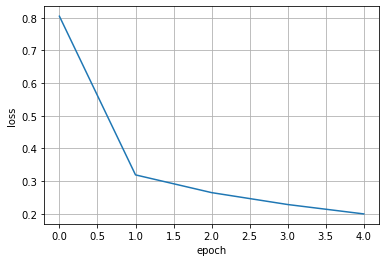

In [81]:
plt.plot(range(epochs), loss_epoch)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

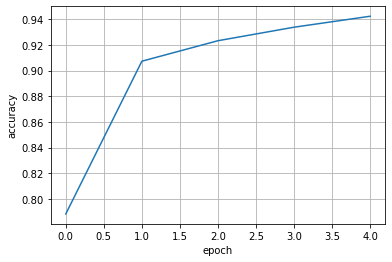

In [82]:
plt.plot(range(epochs), acc_epoch)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()

In [83]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

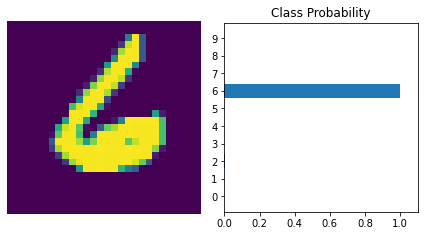

In [93]:
images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = softmax(logps)
view_classify(img.view(1, 28, 28), ps)

In [92]:
labels[0]

tensor(8)